*Este notebook lo utilizamos como base para hacer el fichero de Scrip.py*

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
airbnb_train = pd.read_csv('airbnb_train.csv', sep=';', decimal='.')
airbnb_test = pd.read_csv('airbnb_test.csv', sep=';', decimal='.')

In [13]:
def Preprocesado(df):
    fill_mode = ['Host Total Listings Count', 'Bathrooms', 'Bedrooms', 'Beds']

    fill_mean = ['Host Response Rate',
             'Cleaning Fee',
             'Review Scores Rating',
             'Review Scores Accuracy',
             'Review Scores Cleanliness',
             'Review Scores Checkin',
             'Review Scores Communication',
             'Review Scores Location',
             'Review Scores Value',
             'Reviews per Month']

    date_change = ['Host Since', 'First Review', 'Last Review']

    objects_null = ['Host Since', 'Host Response Time', 'District', 'Room Type',
                'Amenities',
                'First Review',
                'Last Review',
                'Zipcode',
                'Neighbourhood',
                'Host Verifications',
                'Features',
                'Property Type',
                'Bed Type',
                'Calendar Updated',
                'Cancellation Policy']

    categorical = ['Host Since', 'Host Response Time', 'District', 'Room Type',
                'Amenities',
                'First Review',
                'Last Review',
                'Zipcode',
                'Neighbourhood',
                'Host Verifications',
                'Features',
                'Property Type',
                'Bed Type',
                'Calendar Updated',
                'Cancellation Policy']

    minimo = 10

    cols_less_minimo = ['Host Since', 'Host Response Time', 'District', 'Room Type',
                    'Amenities',
                'First Review',
                'Last Review',
                'Zipcode',
                'Neighbourhood',
                'Host Verifications',
                'Features',
                'Property Type',
                'Bed Type',
                'Calendar Updated',
                'Cancellation Policy']

    dict_more_minimo = {}

    for col in cols_less_minimo:
        s = df[col].value_counts()
        dict_more_minimo[col] = (s[s>minimo].index).to_list()


    def check_minimo (x, col):

        if (x != 'Desconocido') and (x not in dict_more_minimo[col]):
          x = 'Otros'

        return x

    Lat_avg = df['Latitude'].mean()
    Long_avg = df['Longitude'].mean()

    # airbnb_train = pd.read_csv('airbnb_train.csv', sep=';', decimal='.')

    # Eliminación de outliers
    df = df.loc[df['Extra People'] < 50]
    df = df.loc[df['Minimum Nights'] < 100]
    df = df.loc[df['Maximum Nights'] < 1200]
    df = df.loc[df['Price'] < 400]

    # Eliminación de algunas columnas
    df = df.drop(['Host Listings Count', 'Weekly Price', 'Monthly Price', 'Security Deposit'], axis=1)

    # Imputación en columnas numéricas
    for col in fill_mode:
        df[col].fillna(df[col].mode()[0], inplace=True)

    for col in fill_mean:
        df[col].fillna(df[col].mean(), inplace=True)

    # Transformación de columnas de fechas
    for col in date_change:
        df[col] = df[col].str[0:7]

    # Imputación en columnas string
    for col in objects_null:
        df[col].fillna('Desconocido', inplace=True)

    # Agrupación de registros poco comunes en columnas string
    for col in cols_less_minimo:
        df[col] = df[col].apply(check_minimo, args = [col])

    # Encoding columnas string
    mean_map = {}
    for c in categorical:
        mean = df.groupby(c)['Price'].mean()
        df[c] = df[c].map(mean)
        mean_map[c] = mean

    # Definición de nuevas columnas
    df['Distance_Center'] = ( (df['Latitude'] - Lat_avg)**2 + (df['Longitude'] - Long_avg)**2 ) ** (0.5)

    return df
    

In [6]:
df = Preprocesado(airbnb_train)

C:\Users\guill\AppData\Local\Temp\ipykernel_15620\3611380896.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\guill\AppData\Local\Temp\ipykernel_15620\3611380896.py:91: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10442 entries, 0 to 10585
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      10442 non-null  float64
 1   Host Response Time              10442 non-null  float64
 2   Host Response Rate              10442 non-null  float64
 3   Host Total Listings Count       10442 non-null  float64
 4   Host Verifications              10442 non-null  float64
 5   Neighbourhood                   10442 non-null  float64
 6   District                        10442 non-null  float64
 7   Zipcode                         10442 non-null  float64
 8   Latitude                        10442 non-null  float64
 9   Longitude                       10442 non-null  float64
 10  Property Type                   10442 non-null  float64
 11  Room Type                       10442 non-null  float64
 12  Accommodates                    10442

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Since,10442.0,63.552385,0.173246,53.333333,63.555321,63.555321,63.555321,63.555321
Host Response Time,10442.0,63.552385,3.863242,55.822706,65.250942,65.780866,65.780866,67.677570
Host Response Rate,10442.0,94.867737,14.227047,0.000000,94.867737,100.000000,100.000000,100.000000
Host Total Listings Count,10442.0,9.759242,27.621265,0.000000,1.000000,2.000000,5.000000,265.000000
Host Verifications,10442.0,63.552385,8.682242,32.314286,59.594595,61.474427,69.751661,121.277778
Neighbourhood,10442.0,63.552385,16.722568,21.625000,52.758621,63.880952,76.664685,114.136986
District,10442.0,63.552385,12.918032,32.323944,52.290323,70.872652,70.872652,81.222714
Zipcode,10442.0,63.552385,14.574089,26.741935,59.064748,65.382952,70.980797,108.194118
Latitude,10442.0,40.420572,0.020232,40.332908,40.410058,40.418626,40.427885,40.514247
Longitude,10442.0,-3.696953,0.023603,-3.835498,-3.707675,-3.701573,-3.693656,-3.573613


In [10]:
df_test = Preprocesado(airbnb_test)

C:\Users\guill\AppData\Local\Temp\ipykernel_15620\3611380896.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\guill\AppData\Local\Temp\ipykernel_15620\3611380896.py:91: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2604 entries, 1 to 2646
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      2604 non-null   float64
 1   Host Response Time              2604 non-null   float64
 2   Host Response Rate              2604 non-null   float64
 3   Host Total Listings Count       2604 non-null   float64
 4   Host Verifications              2604 non-null   float64
 5   Neighbourhood                   2604 non-null   float64
 6   District                        2604 non-null   float64
 7   Zipcode                         2604 non-null   float64
 8   Latitude                        2604 non-null   float64
 9   Longitude                       2604 non-null   float64
 10  Property Type                   2604 non-null   float64
 11  Room Type                       2604 non-null   float64
 12  Accommodates                    2604 no

In [12]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Since,2604.0,63.860215,0.000000,63.860215,63.860215,63.860215,63.860215,63.860215
Host Response Time,2604.0,63.860215,5.275909,52.914201,62.510204,66.989466,66.989466,66.989466
Host Response Rate,2604.0,94.690644,14.084757,0.000000,94.690644,100.000000,100.000000,100.000000
Host Total Listings Count,2604.0,9.809140,27.297061,0.000000,1.000000,2.000000,5.000000,207.000000
Host Verifications,2604.0,63.860215,7.683168,46.272727,59.944954,63.187017,70.559543,89.214286
Neighbourhood,2604.0,63.860215,16.529106,23.866667,50.888889,63.571429,71.316514,135.000000
District,2604.0,63.860215,12.678276,30.144578,59.537634,70.193764,70.193764,77.181818
Zipcode,2604.0,63.860215,14.491711,28.533333,53.230769,66.191489,69.294766,101.617021
Latitude,2604.0,40.420226,0.019680,40.331888,40.409854,40.418370,40.427588,40.513673
Longitude,2604.0,-3.697812,0.022957,-3.822403,-3.708215,-3.701781,-3.694489,-3.579183


In [30]:
def Preprocesado_train_test(df, df_test):
    fill_mode = ['Host Total Listings Count', 'Bathrooms', 'Bedrooms', 'Beds']

    fill_mean = ['Host Response Rate',
             'Cleaning Fee',
             'Review Scores Rating',
             'Review Scores Accuracy',
             'Review Scores Cleanliness',
             'Review Scores Checkin',
             'Review Scores Communication',
             'Review Scores Location',
             'Review Scores Value',
             'Reviews per Month']

    date_change = ['Host Since', 'First Review', 'Last Review']

    objects_null = ['Host Since', 'Host Response Time', 'District', 'Room Type',
                'Amenities',
                'First Review',
                'Last Review',
                'Zipcode',
                'Neighbourhood',
                'Host Verifications',
                'Features',
                'Property Type',
                'Bed Type',
                'Calendar Updated',
                'Cancellation Policy']

    categorical = ['Host Since', 'Host Response Time', 'District', 'Room Type',
                'Amenities',
                'First Review',
                'Last Review',
                'Zipcode',
                'Neighbourhood',
                'Host Verifications',
                'Features',
                'Property Type',
                'Bed Type',
                'Calendar Updated',
                'Cancellation Policy']

    minimo = 10

    cols_less_minimo = ['Host Since', 'Host Response Time', 'District', 'Room Type',
                    'Amenities',
                'First Review',
                'Last Review',
                'Zipcode',
                'Neighbourhood',
                'Host Verifications',
                'Features',
                'Property Type',
                'Bed Type',
                'Calendar Updated',
                'Cancellation Policy']

    dict_more_minimo = {}

    for col in cols_less_minimo:
        s = df[col].value_counts()
        dict_more_minimo[col] = (s[s>minimo].index).to_list()


    def check_minimo (x, col):

        if (x != 'Desconocido') and (x not in dict_more_minimo[col]):
          x = 'Otros'

        return x

    Lat_avg = df['Latitude'].mean()
    Long_avg = df['Longitude'].mean()

    # airbnb_train = pd.read_csv('airbnb_train.csv', sep=';', decimal='.')

    # Eliminación de outliers
    df = df.loc[df['Extra People'] < 50]
    df = df.loc[df['Minimum Nights'] < 100]
    df = df.loc[df['Maximum Nights'] < 1200]
    df = df.loc[df['Price'] < 400]

    # Eliminación de algunas columnas
    df = df.drop(['Host Listings Count', 'Weekly Price', 'Monthly Price', 'Security Deposit'], axis=1)

    # Imputación en columnas numéricas
    for col in fill_mode:
        df[col].fillna(df[col].mode()[0], inplace=True)

    for col in fill_mean:
        df[col].fillna(df[col].mean(), inplace=True)

    # Transformación de columnas de fechas
    for col in date_change:
        df[col] = df[col].str[0:7]

    # Imputación en columnas string
    for col in objects_null:
        df[col].fillna('Desconocido', inplace=True)

    # Agrupación de registros poco comunes en columnas string
    for col in cols_less_minimo:
        df[col] = df[col].apply(check_minimo, args = [col])

    # Encoding columnas string
    mean_map = {}
    for c in categorical:
        mean = df.groupby(c)['Price'].mean()
        df[c] = df[c].map(mean)
        mean_map[c] = mean

    # Definición de nuevas columnas
    df['Distance_Center'] = ( (df['Latitude'] - Lat_avg)**2 + (df['Longitude'] - Long_avg)**2 ) ** (0.5)


    df_test = df_test.loc[df_test['Extra People'] < 50]
    df_test = df_test.loc[df_test['Minimum Nights'] < 100]
    df_test = df_test.loc[df_test['Maximum Nights'] < 1200]
    df_test = df_test.loc[df_test['Price'] < 400]

    df_test = df_test.drop(['Host Listings Count', 'Weekly Price', 'Monthly Price', 'Security Deposit'], axis=1)


    for col in fill_mode:
        df_test[col].fillna(df[col].mode()[0], inplace=True)

    for col in fill_mean:
        df_test[col].fillna(df[col].mean(), inplace=True)

    for col in date_change:
        df_test[col] = df_test[col].str[0:7]

    for col in objects_null:
        df_test[col].fillna('Desconocido', inplace=True)

    for col in cols_less_minimo:
        df_test[col] = df_test[col].apply(check_minimo, args = [col])

    for c in categorical:
        df_test[c] = df_test[c].map(mean_map[c])

    df_test['Distance_Center'] = ( (df_test['Latitude'] - Lat_avg)**2 + (df_test['Longitude'] - Long_avg)**2 ) ** (0.5)

    return df, df_test

In [31]:
train, test = Preprocesado_train_test(airbnb_train, airbnb_test)

C:\Users\guill\AppData\Local\Temp\ipykernel_15620\4058971133.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\guill\AppData\Local\Temp\ipykernel_15620\4058971133.py:91: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10442 entries, 0 to 10585
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      10442 non-null  float64
 1   Host Response Time              10442 non-null  float64
 2   Host Response Rate              10442 non-null  float64
 3   Host Total Listings Count       10442 non-null  float64
 4   Host Verifications              10442 non-null  float64
 5   Neighbourhood                   10442 non-null  float64
 6   District                        10442 non-null  float64
 7   Zipcode                         10442 non-null  float64
 8   Latitude                        10442 non-null  float64
 9   Longitude                       10442 non-null  float64
 10  Property Type                   10442 non-null  float64
 11  Room Type                       10442 non-null  float64
 12  Accommodates                    10442

In [25]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Since,10442.0,63.552385,0.173246,53.333333,63.555321,63.555321,63.555321,63.555321
Host Response Time,10442.0,63.552385,3.863242,55.822706,65.250942,65.780866,65.780866,67.677570
Host Response Rate,10442.0,94.867737,14.227047,0.000000,94.867737,100.000000,100.000000,100.000000
Host Total Listings Count,10442.0,9.759242,27.621265,0.000000,1.000000,2.000000,5.000000,265.000000
Host Verifications,10442.0,63.552385,8.682242,32.314286,59.594595,61.474427,69.751661,121.277778
Neighbourhood,10442.0,63.552385,16.722568,21.625000,52.758621,63.880952,76.664685,114.136986
District,10442.0,63.552385,12.918032,32.323944,52.290323,70.872652,70.872652,81.222714
Zipcode,10442.0,63.552385,14.574089,26.741935,59.064748,65.382952,70.980797,108.194118
Latitude,10442.0,40.420572,0.020232,40.332908,40.410058,40.418626,40.427885,40.514247
Longitude,10442.0,-3.696953,0.023603,-3.835498,-3.707675,-3.701573,-3.693656,-3.573613


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2604 entries, 1 to 2646
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Since                      2604 non-null   float64
 1   Host Response Time              2604 non-null   float64
 2   Host Response Rate              2604 non-null   float64
 3   Host Total Listings Count       2604 non-null   float64
 4   Host Verifications              2604 non-null   float64
 5   Neighbourhood                   2604 non-null   float64
 6   District                        2604 non-null   float64
 7   Zipcode                         2604 non-null   float64
 8   Latitude                        2604 non-null   float64
 9   Longitude                       2604 non-null   float64
 10  Property Type                   2604 non-null   float64
 11  Room Type                       2604 non-null   float64
 12  Accommodates                    2604 no

In [33]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Since,2604.0,63.555321,0.000000,63.555321,63.555321,63.555321,63.555321,63.555321
Host Response Time,2604.0,63.483355,3.915095,55.822706,65.250942,65.780866,65.780866,67.677570
Host Response Rate,2604.0,94.713631,14.084883,0.000000,94.867737,100.000000,100.000000,100.000000
Host Total Listings Count,2604.0,9.809140,27.297061,0.000000,1.000000,2.000000,5.000000,207.000000
Host Verifications,2604.0,63.717420,8.540689,32.314286,59.594595,61.474427,69.751661,121.277778
Neighbourhood,2604.0,63.284645,16.582875,21.625000,52.758621,63.123077,76.664685,114.136986
District,2604.0,63.744455,12.907274,32.323944,52.290323,70.872652,70.872652,81.222714
Zipcode,2604.0,63.416919,14.728692,26.741935,52.680982,65.382952,70.980797,108.194118
Latitude,2604.0,40.420226,0.019680,40.331888,40.409854,40.418370,40.427588,40.513673
Longitude,2604.0,-3.697812,0.022957,-3.822403,-3.708215,-3.701781,-3.694489,-3.579183


In [60]:
def Normalizacion(df_train, df_test):

    X_train = df_train.drop(['Price'], axis=1).values
    y_train = df_train['Price'].values

    X_test = df_test.drop(['Price'], axis=1).values
    y_test = df_test['Price'].values

    scaler = preprocessing.StandardScaler().fit(X_train)
    XtrainScaled = scaler.transform(X_train)

    XtestScaled = scaler.transform(X_test)

    return XtrainScaled, y_train, XtestScaled, y_test

    

In [36]:
XtrainScaled, y_train, XtestScaled, y_test = Normalizacion(train, test)

In [37]:
def random_forest_regressor(depth, estimators, XtrainScaled, y_train, XtestScaled, y_test):

    randomForest = RandomForestRegressor(max_depth = depth, n_estimators = estimators, max_features='sqrt').fit(XtrainScaled, y_train)
    
    r2_train = round(randomForest.score(XtrainScaled, y_train), 3)
    r2_test = round(randomForest.score(XtestScaled, y_test), 3)

    ytrainRF = randomForest.predict(XtrainScaled)
    ytestRF  = randomForest.predict(XtestScaled)
    
    mseTrainModelRF = mean_squared_error(y_train, ytrainRF)
    mseTestModelRF = mean_squared_error(y_test, ytestRF)

    rmse_train = round(mseTrainModelRF ** 0.5, 1)
    rmse_test = round(mseTestModelRF ** 0.5, 1)

    return r2_train, r2_test, rmse_train, rmse_test


In [44]:
depth = 14
estimators = 150

In [45]:
random_forest_regressor(depth, estimators, XtrainScaled, y_train, XtestScaled, y_test)

(0.918, 0.738, 13.2, 23.4)

In [47]:
def grid_search_RF(X_train, y_train, depth_min, depth_max, estimators, cv):

    maxDepth = range(depth_min, depth_max + 1)
    tuned_parameters = {'max_depth': maxDepth}

    grid = GridSearchCV(RandomForestRegressor(random_state = 0, n_estimators = estimators, max_features = 'sqrt'), param_grid = tuned_parameters,cv = cv, verbose=2)
    grid.fit(X_train, y_train)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))

    scores = np.array(grid.cv_results_['mean_test_score'])
    plt.plot(maxDepth,scores,'-o')
    plt.xlabel('max_depth')
    plt.ylabel('5-fold R2')

    plt.show()

    

In [52]:
depth_min = 1
depth_max = 7
estimators = 150
cv = 5

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=1; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.4s
[CV] END ........................................max_depth=2; total time=   0.5s
[CV] END ........................................max_depth=2; total time=   0.4s
[CV] END ........................................max_depth=2; total time=   0.4s
[CV] END ........................................max_depth=2; total time=   0.4s
[CV] END ........................................max_depth=3; total time=   0.6s
[CV] END ........................................

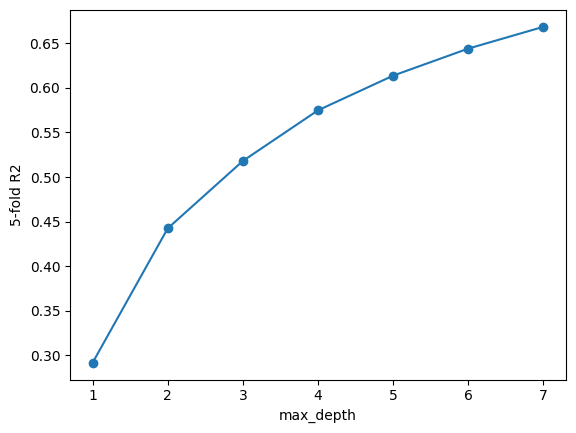

In [53]:
grid_search_RF(XtrainScaled, y_train, depth_min, depth_max, estimators, cv)

In [54]:
airbnb_train.head()

,Host Since,Host Response Time,Host Response Rate,Host Listings Count,Host Total Listings Count,Host Verifications,Neighbourhood,District,Zipcode,Latitude,...,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Features
0,2016-10-03,within a day,80.0,1.0,1.0,"email,phone,reviews",Ambroz,Vicálvaro,28032,40.407075,...,10.0,9.0,10.0,9.0,9.0,10.0,moderate,1.0,1.20,"Host Has Profile Pic,Is Location Exact,Require..."
1,2015-06-16,NaN,NaN,1.0,1.0,"email,phone",Imperial,Arganzuela,28005,40.412418,...,NaN,NaN,NaN,NaN,NaN,NaN,flexible,1.0,NaN,"Host Has Profile Pic,Is Location Exact,Require..."
2,2011-07-20,within a day,75.0,2.0,2.0,"email,phone,reviews,jumio,work_email",Aluche,Latina,28047,40.393056,...,10.0,10.0,10.0,10.0,9.0,10.0,moderate,2.0,1.40,"Host Is Superhost,Host Has Profile Pic,Host Id..."
3,2014-01-07,within an hour,100.0,2.0,2.0,"email,phone,reviews",Lucero,Latina,28011,40.407061,...,NaN,NaN,NaN,NaN,NaN,NaN,flexible,2.0,NaN,"Host Has Profile Pic,Requires License,Instant ..."
4,2012-06-13,within an hour,100.0,2.0,2.0,"email,phone,reviews",Ibiza,Retiro,28009,40.419046,...,10.0,10.0,10.0,10.0,10.0,10.0,strict,1.0,2.36,"Host Is Superhost,Host Has Profile Pic,Require..."


In [56]:
airbnb_train['District'].unique()

array(['Vicálvaro', 'Arganzuela', 'Latina', 'Retiro', 'Centro',
       'Villaverde', 'Salamanca', 'Carabanchel', 'Ciudad Lineal',
       'Puente de Vallecas', 'Fuencarral - El Pardo', 'Hortaleza',
       'Chamberí', 'Tetuán', 'Usera', 'Moncloa - Aravaca',
       'Villa de Vallecas', 'Chamartín', 'Barajas',
       'San Blas - Canillejas', 'Moratalaz'], dtype=object)

In [57]:
distritos = ['Vicálvaro', 'Arganzuela', 'Latina', 'Retiro', 'Centro',
       'Villaverde', 'Salamanca', 'Carabanchel', 'Ciudad Lineal',
       'Puente de Vallecas', 'Fuencarral - El Pardo', 'Hortaleza',
       'Chamberí', 'Tetuán', 'Usera', 'Moncloa - Aravaca',
       'Villa de Vallecas', 'Chamartín', 'Barajas',
       'San Blas - Canillejas', 'Moratalaz']

In [59]:
for dist in distritos:
    media = airbnb_train.loc[airbnb_train['District'] == dist, ]['Price'].mean()
    print(round(media, 1))

35.1
46.4
35.6
69.3
72.7
32.3
86.8
40.3
43.8
35.6
52.3
54.3
71.8
52.2
37.5
68.0
42.2
72.5
51.5
39.8
37.3
